<a href="https://colab.research.google.com/github/Leilusen/Inception_v3_transfer_learning/blob/master/Pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1CAqkffkXX5acaljkgNNps8WjRf44jT4l'})
download.GetContentFile('chest_xray.zip')

from zipfile import ZipFile

with ZipFile('chest_xray.zip', 'r') as zipObj:
   zipObj.extractall()

In [0]:
def weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

In [0]:
data_dir = 'chest_xray'

train_transforms = transforms.Compose([transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(300),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)                                                                 
                                                                                
# Weighted sampler for an unbalanced dataset                       
weights = weights_for_balanced_classes(train_data.imgs, len(train_data.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
trainloader = torch.utils.data.DataLoader(train_data,batch_size=64, sampler=sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
model = models.inception_v3(pretrained=True, transform_input=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False


from collections import OrderedDict

# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
aux_classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(num_ftrs, 2)),
                            ('output', nn.LogSoftmax(dim=1))
                        ]))
    
model.AuxLogits.fc = aux_classifier

# Handle the primary net
num_ftrs = model.fc.in_features
    
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(num_ftrs, 2)),
                            ('output', nn.LogSoftmax(dim=1))
                        ]))
    
model.fc = classifier

model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
params = list(model.fc.parameters()) + list(model.AuxLogits.fc.parameters())
#optimizer = optim.Adam(params, lr = 0.001)
optimizer = optim.SGD(params, lr=0.0003, momentum=0.9)
epochs = 30


train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(epochs):
  
    running_loss = 0
    
    for images, labels in trainloader:
      
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps, aux_log_ps = model.forward(images)
        loss1 = criterion(log_ps, labels)
        loss2 = criterion(aux_log_ps, labels)
        loss = loss1 + 0.4*loss2
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        
    else:
      
        model.eval()
        test_loss = 0
        accuracy = 0

        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            test_loss += loss.item()

            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        test_accuracy.append(accuracy/len(testloader))
        running_loss = 0
        model.train()
            
      
        

Epoch 1/30.. Train loss: 0.896.. Test loss: 0.586.. Test accuracy: 0.789
Epoch 2/30.. Train loss: 0.728.. Test loss: 0.510.. Test accuracy: 0.815
Epoch 3/30.. Train loss: 0.652.. Test loss: 0.507.. Test accuracy: 0.789
Epoch 4/30.. Train loss: 0.616.. Test loss: 0.473.. Test accuracy: 0.795
Epoch 5/30.. Train loss: 0.586.. Test loss: 0.477.. Test accuracy: 0.785
Epoch 6/30.. Train loss: 0.557.. Test loss: 0.440.. Test accuracy: 0.816
Epoch 7/30.. Train loss: 0.537.. Test loss: 0.445.. Test accuracy: 0.798
Epoch 8/30.. Train loss: 0.526.. Test loss: 0.453.. Test accuracy: 0.790
Epoch 9/30.. Train loss: 0.510.. Test loss: 0.435.. Test accuracy: 0.808
Epoch 10/30.. Train loss: 0.515.. Test loss: 0.434.. Test accuracy: 0.812
Epoch 11/30.. Train loss: 0.491.. Test loss: 0.430.. Test accuracy: 0.818
Epoch 12/30.. Train loss: 0.492.. Test loss: 0.416.. Test accuracy: 0.822
Epoch 13/30.. Train loss: 0.486.. Test loss: 0.436.. Test accuracy: 0.802
Epoch 14/30.. Train loss: 0.483.. Test loss: 0.

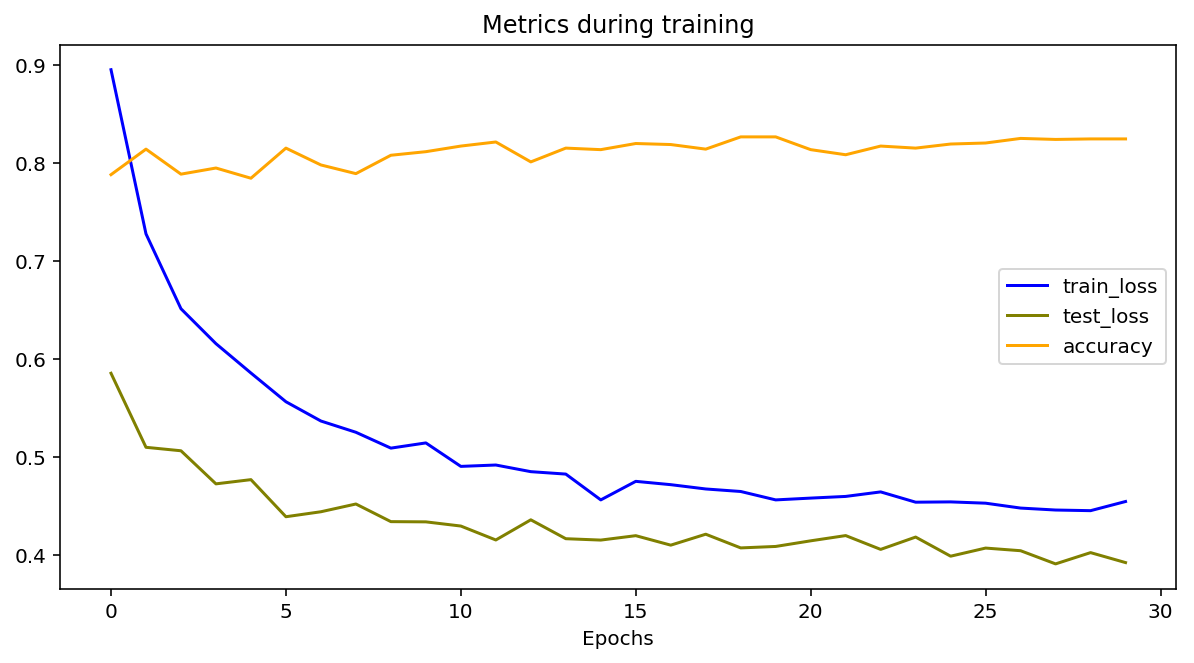

In [26]:
plt.figure(figsize = (10,5))
plt.plot(train_losses, color='blue', label = 'train_loss')
plt.plot(test_losses, color='olive', label = 'test_loss')
plt.plot(test_accuracy, color='orange', label = 'accuracy')
plt.title("Metrics during training")
plt.xlabel("Epochs")
plt.legend(loc='best')
plt.show()

In [0]:
def random_predictions(n_samples=5, test_data = test_data):

  model.cpu()
  model.eval()

  idxs = np.random.randint(len(test_data), size = n_samples)

  labels = [test_data.imgs[i][1] for i in idxs]
  preds = []

  for i, idx in enumerate(idxs):

    img = test_data[idx][0][None,:]
    log_ps = model(img)
    ps = torch.exp(log_ps)
    top_ps, pred = ps.topk(1, dim = 1)
    preds.append(pred)
    
  return idxs, labels, preds


In [0]:
idxs, labels, preds = random_predictions(n_samples=5, test_data = test_data)

In [0]:
def depict_predictions(idxs, labels, preds, test_data = test_data):
  
  plt.figure(figsize=(len(idxs) * 4, 5))
  
  for i, idx in enumerate(idxs):
    
    plt.subplot(1, n_samples, i+1)
    
    img_filepath = test_data.imgs[idx][0]
    img = cv2.imread(img_filepath, 1)
    plt.imshow(img)
    title_text = ("%s%s%s%s%s"%("True: ", labels[i], "\n", "Pred: ", preds[i].item()))
        
    if labels[i]==preds[i]:
        plt.title(title_text)
    else:
        plt.title(title_text, color='red')
            
    plt.axis('off')
    
  plt.show()
  
  return None

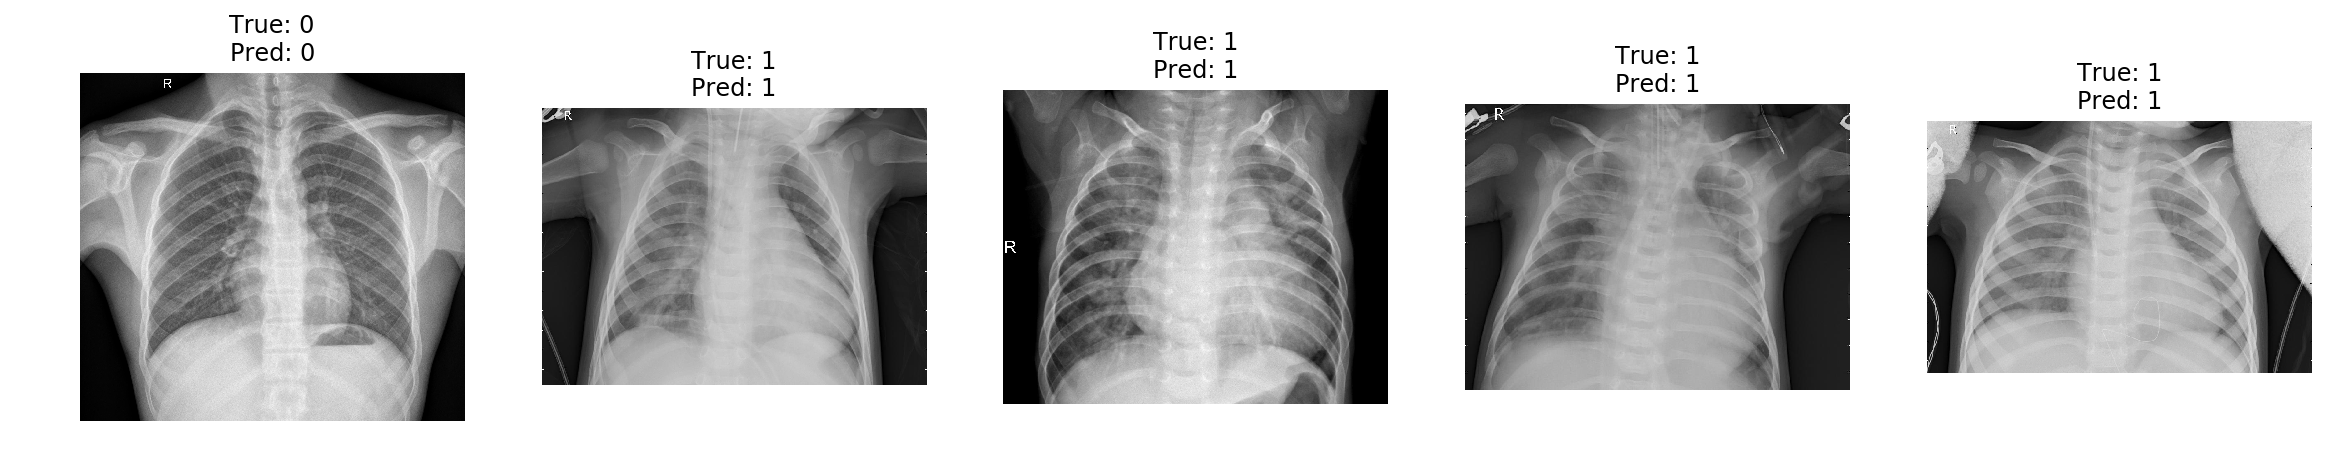

In [128]:
depict_predictions(idxs, labels, preds, test_data = test_data)